In [1]:
import pandas as pd
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
FILE_PATH = "C:\\Users\\quanh\\Desktop\\datasets\\06\\driving_log.csv"

In [3]:
df = pd.read_csv(FILE_PATH,
                names=['center','left','right','steering','throttle','break','speed'], header=None)

In [4]:
df.columns

Index(['center', 'left', 'right', 'steering', 'throttle', 'break', 'speed'], dtype='object')

In [5]:
df.count()

center      8012
left        8012
right       8012
steering    8012
throttle    8012
break       8012
speed       8012
dtype: int64

In [6]:
df.head(10)

,center,left,right,steering,throttle,break,speed
0,C:\Users\quanh\Desktop\datasets\06\IMG\center_...,C:\Users\quanh\Desktop\datasets\06\IMG\left_20...,C:\Users\quanh\Desktop\datasets\06\IMG\right_2...,0.0,0.0,0,0.000008
1,C:\Users\quanh\Desktop\datasets\06\IMG\center_...,C:\Users\quanh\Desktop\datasets\06\IMG\left_20...,C:\Users\quanh\Desktop\datasets\06\IMG\right_2...,0.0,0.0,0,0.000009
2,C:\Users\quanh\Desktop\datasets\06\IMG\center_...,C:\Users\quanh\Desktop\datasets\06\IMG\left_20...,C:\Users\quanh\Desktop\datasets\06\IMG\right_2...,0.0,0.0,0,0.000010
3,C:\Users\quanh\Desktop\datasets\06\IMG\center_...,C:\Users\quanh\Desktop\datasets\06\IMG\left_20...,C:\Users\quanh\Desktop\datasets\06\IMG\right_2...,0.0,0.0,0,0.000008
4,C:\Users\quanh\Desktop\datasets\06\IMG\center_...,C:\Users\quanh\Desktop\datasets\06\IMG\left_20...,C:\Users\quanh\Desktop\datasets\06\IMG\right_2...,0.0,0.0,0,0.000008
5,C:\Users\quanh\Desktop\datasets\06\IMG\center_...,C:\Users\quanh\Desktop\datasets\06\IMG\left_20...,C:\Users\quanh\Desktop\datasets\06\IMG\right_2...,0.0,0.0,0,0.000009
6,C:\Users\quanh\Desktop\datasets\06\IMG\center_...,C:\Users\quanh\Desktop\datasets\06\IMG\left_20...,C:\Users\quanh\Desktop\datasets\06\IMG\right_2...,0.0,0.0,0,0.000009
7,C:\Users\quanh\Desktop\datasets\06\IMG\center_...,C:\Users\quanh\Desktop\datasets\06\IMG\left_20...,C:\Users\quanh\Desktop\datasets\06\IMG\right_2...,0.0,0.0,0,0.000013
8,C:\Users\quanh\Desktop\datasets\06\IMG\center_...,C:\Users\quanh\Desktop\datasets\06\IMG\left_20...,C:\Users\quanh\Desktop\datasets\06\IMG\right_2...,0.0,0.0,0,0.000002
9,C:\Users\quanh\Desktop\datasets\06\IMG\center_...,C:\Users\quanh\Desktop\datasets\06\IMG\left_20...,C:\Users\quanh\Desktop\datasets\06\IMG\right_2...,0.0,0.0,0,0.000006


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000228046F6160>]], dtype=object)

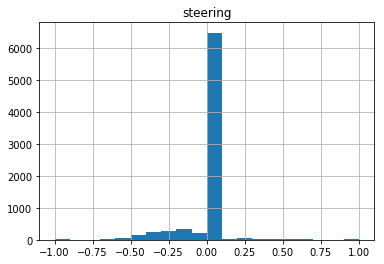

In [7]:
df.hist(column='steering', bins=20)

In [8]:
df = df.drop(df.query('steering == 0').sample(frac=.95).index) # Drop 95% of 0 steering

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022804A0B208>]], dtype=object)

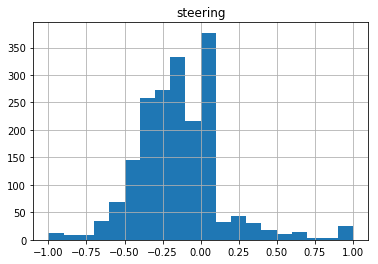

In [9]:
df.hist(column='steering', bins=20)

In [10]:
df.count()

center      1916
left        1916
right       1916
steering    1916
throttle    1916
break       1916
speed       1916
dtype: int64

In [11]:
train_data = df['center'].tolist()
train_labels = df['steering'].tolist()
print(len(train_data))
print(len(train_labels))
print(train_data[10])
print(train_labels[10])

1916
1916
C:\Users\quanh\Desktop\datasets\06\IMG\center_2018_01_15_03_03_04_339.jpg
0.009389671


In [12]:
IMAGE_SIZE=64

In [13]:
def _parse_function(filename, label):
    with tf.device('/cpu:0'):
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string)
    return image_decoded, label

In [14]:
def _preprocessing(image,label, is_training):
    with tf.device('/cpu:0'):
        flip = tf.random_uniform([1], -1, 1)[0] > 0
        image = tf.image.crop_to_bounding_box(image, 60, 0, 100, 320)
        image = tf.cond(flip, lambda: tf.image.flip_left_right(image), lambda: image)
        label = tf.cond(flip, lambda: -label, lambda: label)
        image = tf.image.per_image_standardization(image)
    return image, label

In [15]:
def get_input_fn(list_data, list_labels, mode=tf.estimator.ModeKeys.TRAIN, batch_size=64):
    def _input_fn():
        
        is_training = (mode == tf.estimator.ModeKeys.TRAIN)
        dataset = tf.data.Dataset.from_tensor_slices((list_data, list_labels)) 

        dataset = dataset.shuffle(buffer_size= 2 * batch_size + 1)
        
        dataset = dataset.map(_parse_function, num_parallel_calls=4)
        
        dataset = dataset.map(lambda image, label: (_preprocessing(image, label, is_training)), num_parallel_calls=8)
        
        dataset = dataset.prefetch(batch_size * 4 + 1)
        
        dataset = dataset.repeat()
        
        dataset = dataset.batch(batch_size)
        
        iterator = dataset.make_one_shot_iterator()
        
        images, labels = iterator.get_next()
        images = tf.image.resize_images(images, [IMAGE_SIZE, IMAGE_SIZE])
        return images, labels
        
    return _input_fn

In [16]:
train_input_fn = get_input_fn(train_data, train_labels)
test_input_fn = get_input_fn(train_data, train_labels, tf.estimator.ModeKeys.EVAL)

images_batch size (64, 64, 64, 3)
labels_batch size (64,)
labels_batch[0] -0.028169


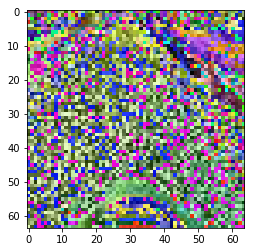

In [17]:
images, labels = train_input_fn()
with tf.Session() as sess:
    for i in range(1):
        images_batch, labels_batch = sess.run([images, labels])
        print("images_batch size", images_batch.shape)
        print("labels_batch size", labels_batch.shape)
        print("labels_batch[0]", labels_batch[0])
        plt.imshow(images_batch[0])
        plt.show()

In [18]:
def my_model_fn(features, labels, mode):
    """Model function for our CNN"""
    
    net = tf.reshape(features, [-1, IMAGE_SIZE, IMAGE_SIZE, 3])
    
    for _ in range(3):
        net = tf.layers.conv2d(
            inputs=net,
            filters=32,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu
        )
        net = tf.layers.max_pooling2d(
            inputs=net,
            pool_size=[2, 2],
            strides=[2,2]
        )
    for _ in range(2):
        net = tf.layers.conv2d(
            inputs=net,
            filters=64,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu
        )
        net = tf.layers.max_pooling2d(
            inputs=net,
            pool_size=[2, 2],
            strides=[2,2]
        )        
    net = tf.layers.flatten(net)
    net = tf.layers.dense(inputs=net, units=512)
    net = tf.layers.dense(inputs=net, units=128)
    net = tf.layers.dense(inputs=net, units=10)
    logits = tf.layers.dense(inputs=net, units=1) # only steering angle
    output = tf.squeeze(logits)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            "output": output,
        }
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.mean_squared_error(labels, output)
    
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
    
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(labels, output)
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, 
        loss=loss, 
        train_op=train_op,
        eval_metric_ops=eval_metric_ops)

In [19]:
my_estimator = tf.estimator.Estimator(
    model_fn=my_model_fn,
    model_dir="E:\\temp\\my_estimator"
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_tf_random_seed': None, '_is_chief': True, '_task_id': 0, '_task_type': 'worker', '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_service': None, '_master': '', '_save_checkpoints_secs': 600, '_model_dir': 'E:\\temp\\my_estimator', '_save_summary_steps': 100, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000022804AE9860>, '_save_checkpoints_steps': None}


In [20]:
train_spec = tf.estimator.TrainSpec(
    input_fn=train_input_fn,
    max_steps=5000
)

test_spec = tf.estimator.EvalSpec(
    input_fn=test_input_fn,
    steps=50, throttle_secs=60
)

In [21]:
tf.estimator.train_and_evaluate(my_estimator, train_spec, test_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 60 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into E:\temp\my_estimator\model.ckpt.
INFO:tensorflow:step = 1, loss = 0.584787
INFO:tensorflow:global_step/sec: 17.0749
INFO:tensorflow:step = 101, loss = 0.0395434 (5.861 sec)
INFO:tensorflow:global_step/sec: 19.6134
INFO:tensorflow:step = 201, loss = 0.0494057 (5.098 sec)
INFO:tensorflow:global_step/sec: 19.5213
INFO:tensorflow:step = 301, loss = 0.0267567 (5.126 sec)
INFO:tensorflow:global_step/sec: 19.3772
INFO:tensorflow:step = 401, loss = 0.0373968 (5.157 sec)
INFO:tensorflow:global_step/sec: 19.4679
INFO:tensorflow:step = 501, loss = 0.0319365 (5.140 sec)
INFO:tensorflow:global_step/sec: 19.5251
INFO:tensorflow:step = 601, loss = 0.0291568 (5.121 sec)
INFO:tensorflow:global_step/sec: 19

INFO:tensorflow:Saving checkpoints for 3135 into E:\temp\my_estimator\model.ckpt.
INFO:tensorflow:Loss for final step: 0.00276522.
INFO:tensorflow:Starting evaluation at 2018-01-15-14:18:05
INFO:tensorflow:Restoring parameters from E:\temp\my_estimator\model.ckpt-3135
INFO:tensorflow:Evaluation [1/50]
INFO:tensorflow:Evaluation [2/50]
INFO:tensorflow:Evaluation [3/50]
INFO:tensorflow:Evaluation [4/50]
INFO:tensorflow:Evaluation [5/50]
INFO:tensorflow:Evaluation [6/50]
INFO:tensorflow:Evaluation [7/50]
INFO:tensorflow:Evaluation [8/50]
INFO:tensorflow:Evaluation [9/50]
INFO:tensorflow:Evaluation [10/50]
INFO:tensorflow:Evaluation [11/50]
INFO:tensorflow:Evaluation [12/50]
INFO:tensorflow:Evaluation [13/50]
INFO:tensorflow:Evaluation [14/50]
INFO:tensorflow:Evaluation [15/50]
INFO:tensorflow:Evaluation [16/50]
INFO:tensorflow:Evaluation [17/50]
INFO:tensorflow:Evaluation [18/50]
INFO:tensorflow:Evaluation [19/50]
INFO:tensorflow:Evaluation [20/50]
INFO:tensorflow:Evaluation [21/50]
INFO:

INFO:tensorflow:Evaluation [38/50]
INFO:tensorflow:Evaluation [39/50]
INFO:tensorflow:Evaluation [40/50]
INFO:tensorflow:Evaluation [41/50]
INFO:tensorflow:Evaluation [42/50]
INFO:tensorflow:Evaluation [43/50]
INFO:tensorflow:Evaluation [44/50]
INFO:tensorflow:Evaluation [45/50]
INFO:tensorflow:Evaluation [46/50]
INFO:tensorflow:Evaluation [47/50]
INFO:tensorflow:Evaluation [48/50]
INFO:tensorflow:Evaluation [49/50]
INFO:tensorflow:Evaluation [50/50]
INFO:tensorflow:Finished evaluation at 2018-01-15-14:20:09
INFO:tensorflow:Saving dict for global step 5000: global_step = 5000, loss = 0.00357471, rmse = 0.0597889


In [38]:
predict_input_fn = get_input_fn(train_data[0:10], train_labels[0:10], tf.estimator.ModeKeys.PREDICT)

In [39]:
predictions = my_estimator.predict(input_fn=predict_input_fn)

In [35]:
predictions

<generator object Estimator.predict at 0x00000229D6053C50>

In [40]:
outputs = []
N = 10

for i, output in enumerate(predictions):
    if i == N:
        break
    outputs.append(output['output'])
print(outputs)

INFO:tensorflow:Restoring parameters from E:\temp\my_estimator\model.ckpt-5000
[0.078390844, 0.053177118, 0.02075159, 0.040205192, 0.014565398, 0.06641838, 0.053918242, 0.037990037, -0.017086534, 0.073967986]


In [41]:
import itertools

In [42]:
list(itertools.islice(predictions, 5))

[{'output': 0.053177118},
 {'output': 0.014565398},
 {'output': -0.0084536998},
 {'output': 0.06641838},
 {'output': 0.022791404}]